## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [2]:
import pandas as pd
import gzip as gz
import matplotlib.pyplot as plt
import sqlite3
import os
import zipfile
import seaborn as sns
import math
import random
from sklearn.linear_model import LinearRegression

In [3]:
# Opened the relevant datasets to be explored in jupyter notebook
#if not os.path.exists('zippedData/im.db'):
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip,path='zippedData/')
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)

In [4]:
# Connected to and opened the imdb database to utilize the data
im_db = sqlite3.connect('zippedData/im.db')
imdb_df = pd.read_sql("""SELECT * FROM movie_basics""",im_db)

In [5]:
# Created a SQL query to pull director name and info from the imdb database
director_info = """
SELECT
    m.movie_id,
    m.primary_title,
    m.genres,
    d.person_id,
    p.primary_name,
    p.death_year
    
    
FROM
    movie_basics AS m
    JOIN 
        directors AS d ON m.movie_id = d.movie_id
    JOIN
        known_for AS kf ON m.movie_id = kf.movie_id
    JOIN
        persons AS p ON p.person_id = d.person_id
GROUP BY
    m.movie_id, kf.person_id, p.primary_name
;
"""
director_info_result = pd.read_sql(director_info, im_db)
director_info_result

,movie_id,primary_title,genres,person_id,primary_name,death_year
0,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
1,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
2,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
3,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
4,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
...,...,...,...,...,...,...
991711,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991712,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN
991713,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991714,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN


In [6]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype('int64')
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]
profit = tn_relevant['clean_worldwide']- tn_relevant['clean_budget']
tn_relevant['profit'] = profit
tn_relevant.head()

<ipython-input-6-1177ee1ecce1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_relevant['profit'] = profit


,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,profit
0,Avatar,2009,Dec,425000000,760507625,2015837654,2776345279,2351345279
1,Pirates of the Caribbean: On Stranger Tides,2011,May,410600000,241063875,804600000,1045663875,635063875
2,Dark Phoenix,2019,Jun,350000000,42762350,107000000,149762350,-200237650
3,Avengers: Age of Ultron,2015,May,330600000,459005868,944008095,1403013963,1072413963
4,Star Wars Ep. VIII: The Last Jedi,2017,Dec,317000000,620181382,696540365,1316721747,999721747


In [7]:
def season_category(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return  'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    else:
        return 'Autumn'

In [8]:
print(season_category('Aug'))

Summer


In [26]:
# tn_relevant['Seasons'] = tn_relevant['month'].apply(season_category)
print(season_category.all?)

SyntaxError: invalid syntax (<ipython-input-26-32924ff42d9a>, line 2)

In [10]:
tn_relevant.head()

,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,profit,Seasons
0,Avatar,2009,Dec,425000000,760507625,2015837654,2776345279,2351345279,Winter
1,Pirates of the Caribbean: On Stranger Tides,2011,May,410600000,241063875,804600000,1045663875,635063875,Spring
2,Dark Phoenix,2019,Jun,350000000,42762350,107000000,149762350,-200237650,Summer
3,Avengers: Age of Ultron,2015,May,330600000,459005868,944008095,1403013963,1072413963,Spring
4,Star Wars Ep. VIII: The Last Jedi,2017,Dec,317000000,620181382,696540365,1316721747,999721747,Winter


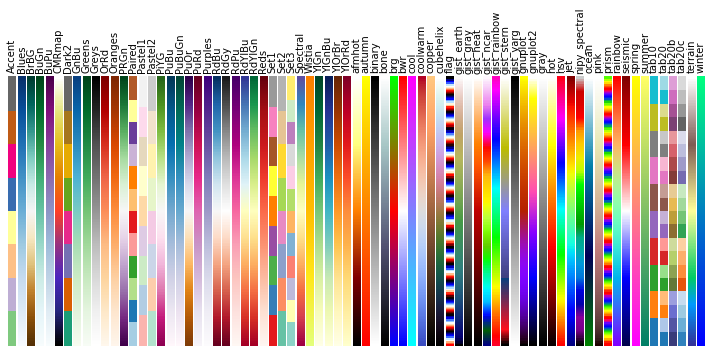

In [53]:
from pylab import *
from numpy import outer
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cm.datad if not m.endswith("_r")]
maps.sort()
l=len(maps)+1
for i, m in enumerate(maps):
     subplot(1,l,i+1)
     axis("off")
     imshow(a,aspect='auto',cmap=get_cmap(m),origin="lower")
     title(m,rotation=90,fontsize=10)
savefig("colormaps.png",dpi=100,facecolor='gray')

<ipython-input-64-1b4a3b547248>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks()//1000000);


Text(0.5, 1.0, 'Median Earning Per Season')

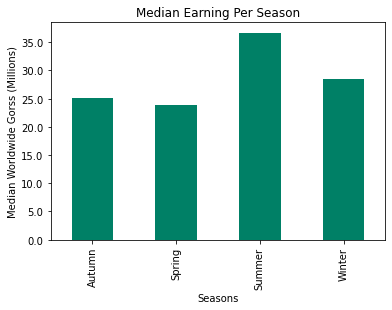

In [64]:
ax3=tn_relevant.groupby('Seasons')['clean_worldwide'].median().plot(kind='bar', stacked=True, colormap='summer')

ax3.set_ylabel('Median Worldwide Gorss (Millions)');
ax3.set_yticklabels(ax3.get_yticks()//1000000);
ax3.set_title('Median Earning Per Season')



<ipython-input-65-89d9ea5dd1d1>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks()//1000000);


Text(0.5, 1.0, 'Median Earning Per Season')

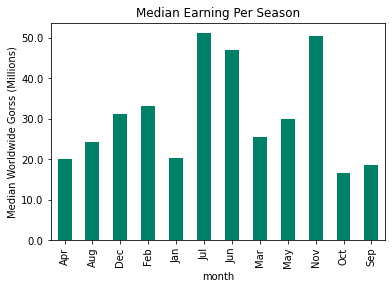

In [65]:
ax3=tn_relevant.groupby('month')['clean_worldwide'].median().plot(kind='bar', stacked=True, colormap='summer')

ax3.set_ylabel('Median Worldwide Gorss (Millions)');
ax3.set_yticklabels(ax3.get_yticks()//1000000);
ax3.set_title('Median Earning Per Season')

In [ ]:
tn_relevant.head()

,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,profit,Seasons
0,Avatar,2009,Dec,425000000,760507625,2015837654,2776345279,2351345279,Winter
1,Pirates of the Caribbean: On Stranger Tides,2011,May,410600000,241063875,804600000,1045663875,635063875,Spring
2,Dark Phoenix,2019,Jun,350000000,42762350,107000000,149762350,-200237650,Summer
3,Avengers: Age of Ultron,2015,May,330600000,459005868,944008095,1403013963,1072413963,Spring
4,Star Wars Ep. VIII: The Last Jedi,2017,Dec,317000000,620181382,696540365,1316721747,999721747,Winter
